# Projet HPC - simulation de processus gaussiens


## ÉCOMPOSITION DE KARHUNEN-LOÈVE 1D

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as sp
import meshio
import time
import seaborn as sns 
import find_roots # https://gist.github.com/np-8/88713c0727af473bc8ac990811f0a446#file-find_roots-py-L33

****

Davidson Lova RAZAFINDRAKOTO

****

### Question 1

La décomposition de Karhunen-Loève est la décomposition d'un processus stochastique dans une famille déterministe orthogonale(ou orthonormale) ponderée par de quantités stochastiques.

Sous reserve de régularité du champs $Z$, On dispose d'une famille orthonormé $(\phi_n)_{n \in \mathbb{N}}$ qui décompose $Z$

$$Z = \sum_{n \in \mathbb{N}} \langle Z, \phi_n \rangle \phi_n$$

(où $\langle .,.\rangle = \langle .,.\rangle_{L^2(\mathcal{J}, \mathbb{R})}$)


On dispose de $K$ le noyau de covariance de $Z$ ce qui nous donne :

+ $(\phi_n)_{n \in \mathbb{N}}$ est une famille de fonction orthonormale sur $\mathcal{J}$ et sont les fonctions propres de l'opérateur $T_K : \phi \mapsto \int_{\mathcal{J}} K(x,y) \phi(y) dy$

+ $\lambda_n$ est valeur propre associer à la fonction propre $\phi_n$ de $T_K$

Il se trouve que cette famille $(\phi_n)_{n \in \mathbb{N}}$ décompose bien $Z$, ce qui nous donne la formule suivante

$$\forall x \in \mathcal{J}, \omega \in \Omega, Z(x, \omega) = \sum_{n \geq 0} \sqrt{\lambda_n} \phi_n(x) \xi_n(\omega)$$

avec 

+ $(\xi_n = \frac{1}{\sqrt{\lambda_n}}\langle Z, \phi_n \rangle)_{n \in \mathbb{N}}$ est une famille de variables aléatories non corélé de moyenne nule
  
+  $ \forall \omega \in \Omega, \xi_n(\omega) = \frac{1}{\sqrt{\lambda_n}} \int_{\mathcal{J}} Z(x,\omega) \phi_n(x) dx$


Dans le cas où $Z$  est un <span style = "color:red"> processus gaussien </span>, les $\xi_n$ sont des gaussiens qui en plus d'être non corélée sont indépendantes. 

Ce qui fait que $\forall x \in \mathcal{J}, Z(x)  \sim \mathcal{N}(\mu_{Z(x)}, \sigma^2_{Z(x)})$ car d'abord $Z$ est un processus gaussien et ensuite c'est une combinaison linéaire de gaussien indépendante.

Si on veut générer une trajectoire d'un processus gaussien de moyenne nule avec la noyau de corélation $K$ sur $\mathcal{J}$, il suffirait d'avoir $(\lambda_n, \phi_n)_{n \in \mathbb{N}}$ en resolvant le problème de valeur propre associer à l'operateur $T_K$, et d'avoir une famille $(\xi_n)_{n \in \mathbb{N}}$ de gaussien indépendante de moyenne nule.

### Question 2

Pour calculer des approximations des $(\lambda_n, \phi_n)$ on prend une disretisation régulière de l'espace $\mathcal{J}$


$$\int_{\mathcal{J}} K(x,y) \phi(y) dy = \sum_{j = 1}^{N}\int_{x_j}^{x_{j+1}} K(x,y) \phi(y) dy$$

On approxime les integralles par une quadrature point milieu, i.e.

$$ \int_{x_j}^{x_{j+1}} K(x,y) \phi(y) dy \approx  h K(x,y_{j+\frac{1}{2}}) \phi(y_{j+\frac{1}{2}})$$

Ce qui nous donne 

$$\int_{\mathcal{J}} K(x,y) \phi(y) dy \approx \sum_{j = 1}^{N}h K(x,y_{j+\frac{1}{2}}) \phi(y_{j+\frac{1}{2}}) $$


On evalue maintenant en $x = x_{i + \frac{1}{2}}$ pour $i = 1,...,N$

$$(*) \sum_{j = 1}^{N}h K(x_{i + \frac{1}{2}},y_{j+\frac{1}{2}}) \phi(y_{j+\frac{1}{2}}) = \lambda \phi(x_{i + \frac{1}{2}})$$


Soient $K \in \mathbb{R}^{N \times N}$ la matrice tel que $K_{i,j} = K(x_{i + \frac{1}{2}}, y_{j + \frac{1}{2}})$

et $\phi \in \mathbb{R}^N$ le vecteur tel que $\phi_{j} = \phi(y_{j + \frac{1}{2}})$

Ce qui nous donne $$ (*) \Longleftrightarrow h K \phi = \lambda \phi $$

La discretisation nous ramène alors au calcul des valeurs et vecteur propres de la matrice $h K$






### Question 3

Supposant $Z$ avec toute ces propriétés précédente est en plus un processus gaussien

On aura $\forall x \in \mathcal{J}, Z(x) \sim \mathcal{N}(0, V(Z(x)))$ et $V(Z(x)) = Cov(Z(x), Z(x)) = K(x,x) = e^{-\frac{|0|}{\lambda}} = 1$

Donc à chaque point, on s'attend à une gaussien de moyenne nule et variance 1.

Démarche de génération de trajectoire :

+ Résoudre $\int_{\mathcal{J}} K(x,y) \phi(y) dy = \lambda \phi(x)$ i.e pour notre cas discret $h K \phi = \lambda \phi$

+ Tonquer la série en retenant que $N_{KL}$ tq $\sum_{n = 1}^{N_{KL}} \lambda_n \sim 0.95 \sum_{n = 1}^{N} \lambda_n$

+ On tire $N_{KL}$ v.a. iid $\xi_n \sim \mathcal{N}(0,1)$ (on prend $\xi_n$ de variance $1$ toutes parce que pourquoi pas)
+ La trajectoire sera alors le vecteur $Z_{N_{KL}} (x_{i + \frac{1}{2}}) = \sum_{ n = 1}^{N_{KL}}\sqrt{\lambda_n} \phi_{j}^{(n)} \xi_n$ pour $i = 1, ..., N$

In [2]:
def GenererComposante(J, N, partVar, lambdaK):
    h = 2./N
    # Discretisation régulière de J
    x = np.linspace(J[0] + h/2, J[1] - h/2, N - 2)

    # Calcul de la matrice noyau
    K = np.exp(-np.abs(np.subtract.outer(x, x)) / lambdaK)

    # Calcul des valeurs propres et vecteur propres de la matrice h K
    hK = h*K
    hw, hv = np.linalg.eig(hK)

    # Renormalisation
    hv = hv / np.sqrt(h)

    # Troncature
    tracehK = sum(hw)
    Nkl = sum(np.cumsum(hw) < tracehK*partVar) + 1

    return [x, hw, hv, Nkl]


In [3]:
# Paramètre du domaine
J = [-1, 1]
N = 500
partVar = 0.95
lambdaK = 5

x, hw, hv, Nkl = GenererComposante(J, N, partVar, lambdaK)


#### Génération de plusieur trajectoir approché

Text(0.5, 1.0, 'Un exemple de Trajectoire approché avec 95.0% part de variance')

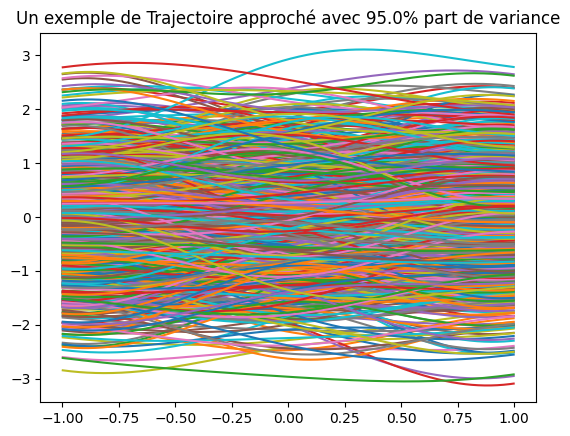

In [4]:
nbTraject = 1000
hwTronc = hw[:Nkl]
Phin = hv[:, :Nkl]
for i in range(nbTraject):

    Xin = np.random.randn(Nkl)

    cn = (np.sqrt(hwTronc)*Xin).reshape(Nkl, 1)

    ZNkl = np.matmul(Phin, cn)
    plt.plot(x, ZNkl)

plt.title("Un exemple de Trajectoire approché avec {}% part de variance".format(
    partVar*100))


#### Une version plus traitable

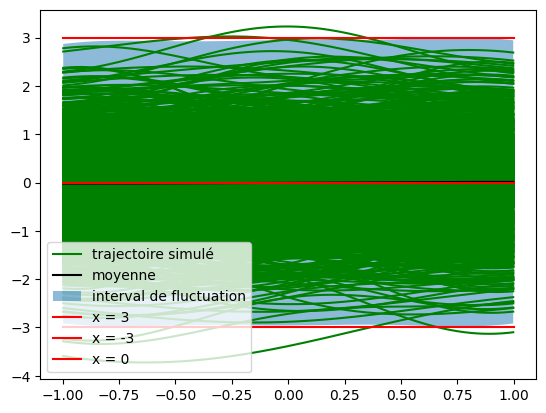

In [5]:
nbTraject = 1000
hwTronc = hw[:Nkl]
Phin = hv[:, :Nkl]
Xink = np.random.randn(nbTraject, Nkl)
lnXin = np.matmul(Xink, np.diag(np.sqrt(hwTronc)))

Z = np.matmul(lnXin, Phin.transpose())

for i in range(nbTraject-1):
    plt.plot(x, Z[i, :], 'green')
plt.plot(x, Z[nbTraject-1, :], 'green', label="trajectoire simulé")


moyenne_approx = np.mean(Z, axis=0)
std_approx = np.std(Z, axis=0)
binf = moyenne_approx - 3*std_approx
bsup = moyenne_approx + 3*std_approx

plt.plot(x, moyenne_approx, label="moyenne", c='k')
plt.fill_between(x, binf, bsup, alpha=0.5, label='interval de fluctuation')

# bor x = +-3 et 0
plt.plot(np.array([-1, 1]), np.array([3, 3]), label="x = 3", c='red')
plt.plot(np.array([-1, 1]), np.array([-3, -3]), label="x = -3", c='red')
plt.plot(np.array([-1, 1]), np.array([0, 0]), label="x = 0", c='red')

plt.legend()
plt.show()


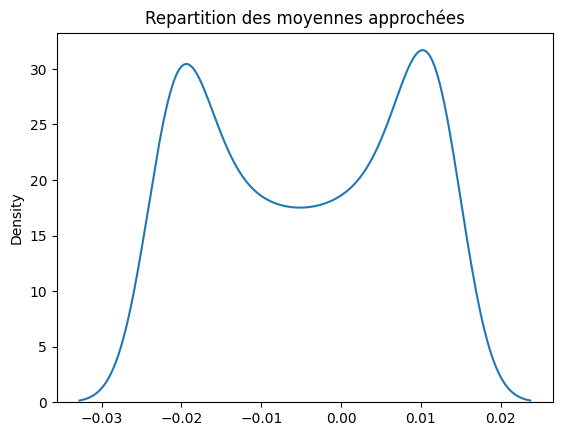

In [8]:
sns.kdeplot(moyenne_approx)
plt.title("Repartition des moyennes approchées")
plt.show()

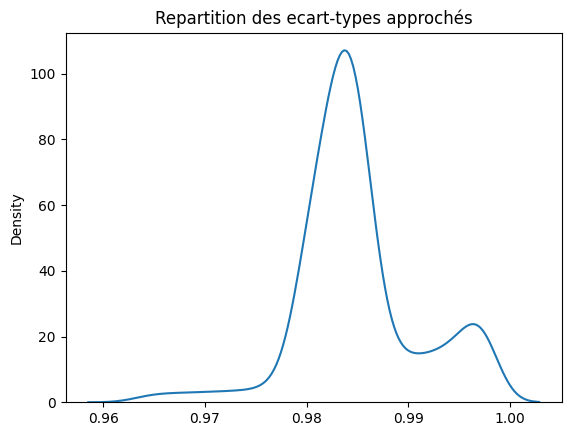

In [9]:
sns.kdeplot(std_approx)
plt.title("Repartition des ecart-types approchés")
plt.show()

+ Moyenne empirique
    Ici en haut on remarque que la courde des moyennes de trajectoires est proches de 0
+ La varariance en chaque point tourne autour de 1
+ En entrée on a donné $\xi_n \sim \mathcal{N}(0,1)$ on a alors $Z_{Nkl} (x_{j+\frac{1}{2}}) = \sum_{ n = 1}^{N_{KL}}\sqrt{\lambda_n} \phi_{j} \xi_n \sim \mathcal{N}(0,V(Z_{Nkl}(x_{j+\frac{1}{2}})))$

In [10]:
def NormalPDF(x) :
    return (1/np.sqrt(np.pi*2)) * np.exp(- (x**2)/2)
x = np.linspace(-4, 4, 100)
y = NormalPDF(x)

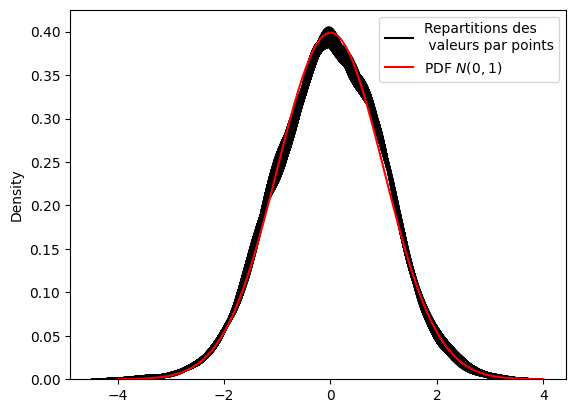

In [13]:
for i in range(N - 3):
    # plt.hist(Z[:, i], color='k', alpha=0.01, density=True)
    sns.kdeplot(Z[:,i], c = 'k')
sns.kdeplot(Z[:,N-3], c = 'k', label = "Repartitions des \n valeurs par points")

plt.plot(x,y, c = 'red', label = f"PDF $N(0,1)$")
plt.legend()
plt.show()


Ici on a illustrée le fait qu'en chaque point, on a une variable aléatoire qui suit une loi normale centrée réduite, en tous cas l'approximation de la densité par lissage à noyau montre une courbe proche de la densité gaussienne.

#### Etude de complexité de la méthode

La compléxité est $\Omicron(N^2)$ où $N$ est le nombre de points dans la discretisation.

In [14]:
def timingTrajGen(J, N, partVar, lambdaK):
    start = time.time()
    _, hw, hv, Nkl = GenererComposante(J, N, partVar, lambdaK)

    hwTronc = hw[:Nkl]
    Phin = hv[:, :Nkl]

    Xin = np.random.randn(Nkl)

    cn = (np.sqrt(hwTronc)*Xin).reshape(Nkl, 1)

    ZNkl = np.matmul(Phin, cn)

    end = time.time()

    return (end - start)


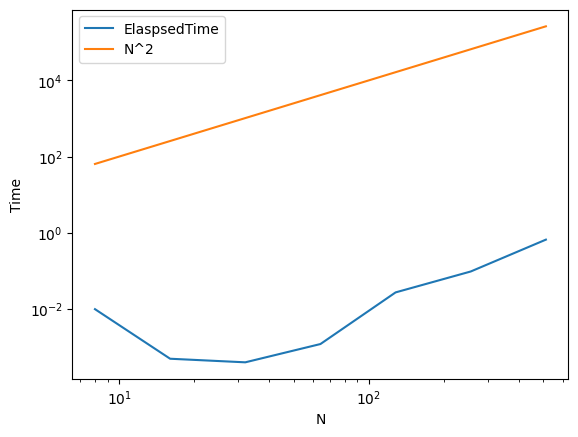

In [15]:
J = [-1, 1]
partVar = 0.95
lambdaK = 5

nMin = 3
nMax = 10
Ns = 2**(np.arange(nMin, nMax))
elapsedTime = [timingTrajGen(J, N, partVar, lambdaK) for N in Ns]
plt.loglog(Ns, elapsedTime, label='ElaspsedTime')
plt.plot(Ns, Ns**2, label='N^2')
plt.xlabel('N')
plt.ylabel('Time')
plt.legend()


### Question 4

$$T_K : f \mapsto \int_{\mathcal{J}} K_{\lambda} (x,y) f(y)dy$$


On cherche à trouver les couples $(L, f)$ tel que 

$\forall x \in \mathcal{J}, T_K(f) = \int_{\mathcal{J}} K_{\lambda} (x,y) f(y)dy = \int_{\mathcal{J}} e^{- \frac{|x - y|}{\lambda}} f(y)dy = Lf(x) $

Ce qui est equivalent à résoudre

$$\forall x \in \mathcal{J}, f(x) = \frac{1}{L} \int_{\mathcal{J}} e^{- \frac{|x - y|}{\lambda}} f(y)dy$$



$\frac{\partial f}{\partial x}(x) = \frac{\partial }{\partial x} \left( \frac{1}{L}\ \int_{\mathcal{J}} e^{- \frac{|x - y|}{\lambda}} f(y)dy\right) = \frac{1}{L} \frac{\partial }{\partial x} \left(  \int_{-1}^x e^{- \frac{|x - y|}{\lambda}} f(y)dy + \int_{x}^1 e^{- \frac{|x - y|}{\lambda}} f(y)dy\right)$

$ = \frac{1}{L} \frac{\partial }{\partial x} \left(\int_{-1}^x e^{- \frac{x - y}{\lambda}} f(y)dy + \int_{x}^1 e^{\frac{x - y}{\lambda}} f(y)dy\right) = \frac{1}{L} \frac{\partial }{\partial x} \left( e^{- \frac{x}{\lambda}}\int_{-1}^x e^{\frac{y}{\lambda}} f(y)dy + e^{\frac{x}{\lambda}} \int_{x}^1 e^{-\frac{y}{\lambda}} f(y)dy \right)$

$ = \frac{1}{L}\left( \left[ -\frac{1}{\lambda}e^{- \frac{x}{\lambda}}\int_{-1}^x e^{\frac{y}{\lambda}} f(y)dy + e^{- \frac{x}{\lambda}} e^{\frac{x}{\lambda}} f(x) \right]+ \left[\frac{1}{\lambda} e^{\frac{x}{\lambda}} \int_{x}^1 e^{-\frac{y}{\lambda}} f(y)dy - e^{\frac{x}{\lambda}} e^{-\frac{x}{\lambda}} f(x) \right] \right)$ 

$ = \frac{1}{\lambda L}\left( -e^{- \frac{x}{\lambda}}\int_{-1}^x e^{\frac{y}{\lambda}} f(y)dy + e^{\frac{x}{\lambda}} \int_{x}^1 e^{-\frac{y}{\lambda}} f(y)dy\right)$

$\frac{\partial^2 f}{\partial x^2}(x) = \frac{\partial }{\partial x}(\frac{\partial f}{\partial x}(x)) = \frac{\partial}{\partial x} \left(\frac{1}{\lambda L}\left( -e^{- \frac{x}{\lambda}}\int_{-1}^x e^{\frac{y}{\lambda}} f(y)dy + e^{\frac{x}{\lambda}} \int_{x}^1 e^{-\frac{y}{\lambda}} f(y)dy\right)\right)$

$ = \frac{1}{\lambda L} \frac{\partial}{\partial x} \left( -e^{- \frac{x}{\lambda}}\int_{-1}^x e^{\frac{y}{\lambda}} f(y)dy + e^{\frac{x}{\lambda}} \int_{x}^1 e^{-\frac{y}{\lambda}} f(y)dy\right)$

$ = \frac{1}{\lambda L} \left( -\left[ -\frac{1}{\lambda}e^{- \frac{x}{\lambda}}\int_{-1}^x e^{\frac{y}{\lambda}} f(y)dy + e^{- \frac{x}{\lambda}} e^{\frac{x}{\lambda}} f(x) \right]+ \left[\frac{1}{\lambda} e^{\frac{x}{\lambda}} \int_{x}^1 e^{-\frac{y}{\lambda}} f(y)dy - e^{\frac{x}{\lambda}} e^{-\frac{x}{\lambda}} f(x)\right]\right)$

$ = \frac{1}{\lambda L} \left( \frac{1}{\lambda} \left(e^{- \frac{x}{\lambda}}\int_{-1}^x e^{\frac{y}{\lambda}} f(y)dy + e^{\frac{x}{\lambda}} \int_{x}^1 e^{-\frac{y}{\lambda}} f(y)dy\right)  - 2f(x)\right)$

$ = \frac{1}{\lambda L} \left( \frac{1}{\lambda} \left(\int_{-1}^x e^{-\frac{x-y}{\lambda}} f(y)dy + \int_{x}^1 e^{\frac{x-y}{\lambda}} f(y)dy\right)  - 2f(x)\right)$

$ = \frac{1}{\lambda L} \left( \frac{1}{\lambda} \left(\int_{-1}^x e^{-\frac{|x-y|}{\lambda}} f(y)dy + \int_{x}^1 e^{-\frac{|x-y|}{\lambda}} f(y)dy\right)  - 2f(x)\right)$

$ = \frac{1}{\lambda L} \left( \frac{1}{\lambda} \left(\int_{-1}^1 e^{-\frac{|x-y|}{\lambda}} f(y)dy\right) - 2f(x)\right) = \frac{1}{\lambda L} \left( \frac{1}{\lambda}L  f(x) - 2f(x)\right) $

$ = \frac{1}{\lambda} \left( \frac{1}{\lambda} - \frac{2}{L}\right)f(x)$ 


$f(1) = Le^{-\frac{1}{\lambda}}\int_{-1}^1 e^{\frac{y}{\lambda}} f(y)dy$

$f(-1) = Le^{-\frac{1}{\lambda}}\int_{-1}^1 e^{-\frac{y}{\lambda}} f(y)dy$

$\frac{\partial f}{\partial x}(1) = -\frac{1}{\lambda L} e^{- \frac{1}{\lambda}}\int_{-1}^1 e^{\frac{y}{\lambda}} f(y)dy$

$\frac{\partial f}{\partial x}(-1) = \frac{1}{\lambda L}e^{-\frac{1}{\lambda}} \int_{-1}^1 e^{-\frac{y}{\lambda}} f(y)dy$

$f$ est alors solution l'équation différentielle 

$$(1) \frac{\partial^2 f}{\partial x^2} - \frac{1}{\lambda} \left( \frac{1}{\lambda} - \frac{2}{L}\right) f = 0$$

avec les conditions limites 

$$(2) f(1) + \lambda \frac{\partial f}{\partial x}(1) = 0$$

$$(3) f(-1) - \lambda \frac{\partial f}{\partial x}(-1) = 0$$ 

C'est une EDO linéaire homogène de second ordre avec un polynome caractéristique $P(x) = x^2 - \frac{1}{\lambda} \left( \frac{1}{\lambda} - \frac{2}{L}\right)$

Ce qui nous donne 3 cas :

+ $\frac{1}{\lambda} \left( \frac{1}{\lambda} - \frac{2}{L}\right) = 0 \Leftrightarrow \frac{1}{\lambda} - \frac{2}{L} = 0 \Leftrightarrow L = 2\lambda$

    on a $f(x) = bx + c$

    $f(1) = b+c$ et $f'(1) = b$ et $f(-1) = -b + c$ et $f'(-1) = b$

    Avec $(2)$ on doit avoir $(b+c) + \lambda b = 0$ et $(3)$, $-b + c - \lambda b = 0$

    En additionant les deux équations on $2c = 0$ et $b = c (\frac{1}{1 + \lambda}) = 0$

    Ce qui nous donne $f = 0$ 

+ $\mu = \sqrt{\frac{1}{\lambda} \left( \frac{1}{\lambda} - \frac{2}{L}\right)} > 0$

    on a $f$ sous la forme $f(x) = a e^{\mu x} + b e^{- \mu x} $

    $f'(x) = \mu(a e^{\mu x} - b e^{- \mu x}) $

    $f(1) = a e^{\mu} + b e^{- \mu} $ et $f'(1) = \mu(a e^{\mu} - b e^{- \mu}) $

    $f(-1) = a e^{-\mu} + b e^{ \mu} $ et $f'(-1) = \mu(a e^{-\mu} - b e^{\mu}) $

    $f(1) + \lambda \frac{\partial f}{\partial x}(1) = a e^{\mu} + b e^{- \mu} +\lambda\mu(a e^{\mu} - b e^{- \mu}) = a e^{\mu}(1 + \lambda \mu ) + b e^{-\mu}(1 - \lambda \mu) = 0$

    $f(-1) - \lambda \frac{\partial f}{\partial x}(-1) = a e^{-\mu} + b e^{ \mu} - \lambda \mu(a e^{-\mu} - b e^{\mu}) = a e^{-\mu}(1 - \lambda \mu) + b e^{\mu}(1 + \lambda \mu ) = 0$

    Soit $A := \begin{pmatrix} e^{\mu}(1 + \lambda \mu ) & e^{-\mu}(1 - \lambda \mu) \\e^{-\mu}(1 - \lambda \mu) & e^{\mu}(1 + \lambda \mu ) \end{pmatrix}$

    Les conditions limites sont équivalent à $A \begin{pmatrix}a \\ b\end{pmatrix} = \begin{pmatrix} 0 \\ 0 \end{pmatrix} $

    $det(A) = e^{2\mu} (1 + \lambda \mu)^2 - e^{-2\mu} (1 - \lambda \mu)^2$

    Si $det(A) \neq 0$, $A$ est inversible donc $\begin{pmatrix}a \\ b\end{pmatrix} = \begin{pmatrix} 0 \\ 0 \end{pmatrix}$ donc $f = 0$

    Si $det(A) = 0$, on a $e^{2\mu} (1 + \lambda \mu)^2 - e^{-2\mu} (1 - \lambda \mu)^2 = 0$ 

    $\Rightarrow e^{2\mu} (1 + \lambda \mu)^2 = e^{-2\mu} (1 - \lambda \mu)^2 \Rightarrow e^{4\mu}  = (\frac{1 - \lambda \mu}{1 + \lambda \mu})^2$

    Ici $\lambda \mu > 0$, ce qui nous donne $(\frac{1 - \lambda \mu}{1 + \lambda \mu})^2 < 1$ et comme $\mu > 0$, on a $e^{4\mu} > 1$ donc l'égalité est impossible. Ce qui fait que $det(A) \neq 1$.

    Finalement on a dans tous les cas, $f = 0$

+ $\frac{1}{\lambda} \left( \frac{1}{\lambda} - \frac{2}{L}\right) < 0$ on a $\frac{1}{\lambda} \left( \frac{2}{L} -\frac{1}{\lambda} \right) > 0$ et si je pose $\nu = \sqrt{\frac{1}{\lambda} \left( \frac{2}{L} -\frac{1}{\lambda} \right)}$

    on a $f$ sous la forme $f(x) = a \cos(\nu x) + b \sin(\nu x) $

    $f'(x) = \nu(-a \sin(\nu x) + b \cos(\nu x))$
    
    $f(1) = a \cos(\nu) + b \sin(\nu)$

    $f'(1) = \nu(-a \sin(\nu) + b \cos(\nu))$

    $f(-1) = a \cos(-\nu) + b \sin(-\nu) = a \cos(\nu) - b \sin(\nu)$

    $f'(-1) = \nu(- a \sin(-\nu) + b \cos(-\nu) ) = \nu(a \sin(\nu) + b \cos(\nu))$

    $f(1) + \lambda \frac{\partial f}{\partial x}(1) = a(\cos(\nu) - \nu \lambda \sin(\nu)) + b(\sin(\nu) + \nu \lambda \cos(\nu)) = 0$

    $f(-1) - \lambda \frac{\partial f}{\partial x}(-1) = a(\cos(\nu) - \nu \lambda \sin(\nu)) - b(\sin(\nu) + \nu \lambda \cos(\nu)) = 0$

    En sommant les deux équations on a $a(\cos(\nu) - \nu \lambda \sin(\nu)) = 0$

    Si $a \neq 0$ on a $\cos(\nu) - \nu \lambda \sin(\nu) = 0$

    Si $\nu = k\pi$, on a $\sin(k \pi) = 0$ donc $\cos(k \pi) = (-1)^k \neq 0$

    Si $\nu = k\pi + \frac{\pi}{2}$, on a $\cos(k \pi + \frac{\pi}{2}) = 0$ donc $\sin(k \pi + \frac{\pi}{2}) = (-1)^k \neq 0$

    On a donc $\cot(\nu) = \lambda \nu$ et $\tan(\nu) = \frac{1}{\lambda \nu}$

    En sommant les deux équations on a $b(\sin(\nu) + \nu \lambda \cos(\nu)) = 0$

    Si $b \neq 0$ on a $\sin(\nu) + \nu \lambda \cos(\nu) \Leftrightarrow - \lambda \nu = \tan(\nu)$

+ si $a \neq 0$, on a $\tan(\nu) = \frac{1}{\lambda \nu} > 0$ donc $b = 0$, donc $f(x) = a \cos(\nu x)$

    Pour déterminer $a$, on veut $\lVert f \rVert = \int_{-1}^{1} (a \cos(\nu x))^2 dx = a^2 \int_{-1}^{1} \cos^2(\nu x) dx = \frac{a^2}{2} \int_{-1}^{1} \left(\cos(2 \nu x) + 1\right) dx  $

    $ = \frac{a^2}{2} \left[\int_{-1}^{1}\cos(2 \nu x) dx + 2\right] = \frac{a^2}{2} \left( [\frac{\sin(2 \nu x)}{2 \nu}]_{-1}^1 + 2\right)  = \frac{a^2}{2} \left( \frac{1}{2 \nu}[\sin(2 \nu) - \sin(- 2 \nu )] + 2\right) $
    
    $ = \frac{a^2}{2} \left( \frac{\sin(2 \nu)}{\nu} + 2\right) = a^2 \left( \frac{\sin(2 \nu)}{2\nu} + 1\right) = 1$ 

    $a = \sqrt{\frac{2\nu}{\sin(2 \nu)+ 2\nu}}$

+ si $b \neq 0$, on a $\tan(\nu) = - \lambda \nu < 0$ donc $a = 0$, donc $f(x) = b \sin(\nu x)$

    Pour déterminer $b$, on veut $\lVert f \rVert = \int_{-1}^{1} (b \sin(\nu x))^2 dx = b^2 \int_{-1}^{1} \sin^2(\nu x) dx = \frac{b^2}{2} \int_{-1}^{1} \left(1 - \cos(2 \nu x)\right) dx  $

    $ = \frac{b^2}{2} \left[2 - \int_{-1}^{1}\cos(2 \nu x) dx\right] = \frac{b^2}{2} \left(2 - [\frac{\sin(2 \nu x)}{2 \nu}]_{-1}^1\right) = \frac{b^2}{2} \left(2 - \frac{1}{2 \nu}[\sin(2 \nu) - \sin(-2 \nu)]\right)$

    $ = \frac{b^2}{2} \left(2 - \frac{\sin(2 \nu)}{ \nu}\right) = b^2 \left(1 - \frac{\sin(2 \nu)}{ 2 \nu}\right) $

    $b = \sqrt{\frac{2\nu}{2\nu - \sin(2 \nu)}}$


$\nu^2 = \frac{1}{\lambda} \left( \frac{2}{L} -\frac{1}{\lambda} \right) \Leftrightarrow \lambda \nu^2 =  \left( \frac{2}{L} -\frac{1}{\lambda} \right) \Leftrightarrow \lambda \nu^2 + \frac{1}{\lambda} = \frac{2}{L} \Leftrightarrow L = \frac{2}{\lambda \nu^2 + \frac{1}{\lambda}} = L = \frac{2 \lambda}{\lambda^2 \nu^2 + 1}  $

Ici on remarque que $L$ est une fonction paire de $\nu$ décroissante sur $\mathbb{R}_+$, elle atteint alors sa valeur maximale en $\mu = 0$, $L = 2\lambda$

Donc dans la suite on a la majoration $L < 2 \lambda$


<span style = "color:yellow"> Conclusion </span> 
    
Nos solutions analytiques sont :

+ $f_\nu^1 : x \in \mathcal{J}\mapsto \sqrt{\frac{2\nu}{\sin(2 \nu)+ 2\nu}} \cos(\nu x)$ pour $\nu > 0$ tq $\cos(\nu) - \nu \lambda \sin(\nu) = 0$ avec $L = \frac{2 \lambda}{\lambda^2 \nu^2 + 1}$
+ $f_\nu^2 : x \in \mathcal{J}  \mapsto \sqrt{\frac{2\nu}{2\nu - \sin(2 \nu)}} \sin(\nu x)$ pour $\nu > 0$ tq $\sin(\nu) + \nu \lambda \cos(\nu) = 0$ avec $L = \frac{2 \lambda}{\lambda^2 \nu^2 + 1}$

On va maintenant vérifier si les fonctions propres approchés numériques sont bien proches des solutions analytiques.

Sachant que les fonctions propres approchés est une famille orthonormé de vecteur, si $\phi_n$ est une fonction propre, $- \phi_n$ associé au même espace propre qui a la même norme.

In [16]:
# Paramètre du domaine
J = [-1, 1]
N = 1000
partVar = 0.95
lambdaK = 5

x, hw, hv, Nkl = GenererComposante(J, N, partVar, lambdaK)

In [17]:
def f1(x, nu):
    return np.sqrt(2 * nu / (np.sin(2 * nu) + 2 * nu)) * np.cos(x * nu)


def f2(x, nu):
    return np.sqrt(2 * nu / (2 * nu - np.sin(2 * nu))) * np.sin(x * nu)


Il nous faut d'abort determiner les racines de fonction
+ $x \in \mathbb{R}_+^* \mapsto \cos(x) - x \lambda \sin(x)$
+ $x \in \mathbb{R}_+^*\mapsto \sin(x) + x \lambda \cos(x)$

In [18]:
def rac1(x, l=lambdaK):
    return np.cos(x) - x * l * np.sin(x)


def rac2(x, l=lambdaK):
    return np.sin(x) + x * l * np.cos(x)


In [19]:
sd = 9
start = 0.001
stop = sd * np.pi
step = 0.001
r = find_roots.RootFinder(start, stop, step)
roots1 = r.find(rac1)


In [20]:
start = 0.001
stop = sd * np.pi
step = 0.001
r = find_roots.RootFinder(start, stop, step)
roots2 = r.find(rac2)


Maintenant qu'on a les racines on va comparer les fonctions analytiques avec le fonction propre apporchés

In [ ]:
# sz = int(np.sqrt(2*sd))+1

# plt.subplots(sz, sz, figsize=(10, 10))
# for i in range(2 * sd):
#     plt.subplot(sz, sz, i+1)
#     plt.plot(x, hv[:, i], label="phi")
#     plt.plot(-x, hv[:, i], label="-phi")
#     if (i % 2 == 0):
#         plt.plot(x, f1(x, roots1[int(i/2)]), label="f1")
#     else:
#         plt.plot(x, f2(x, roots2[int(i/2)]), label="f2")
#     plt.legend()


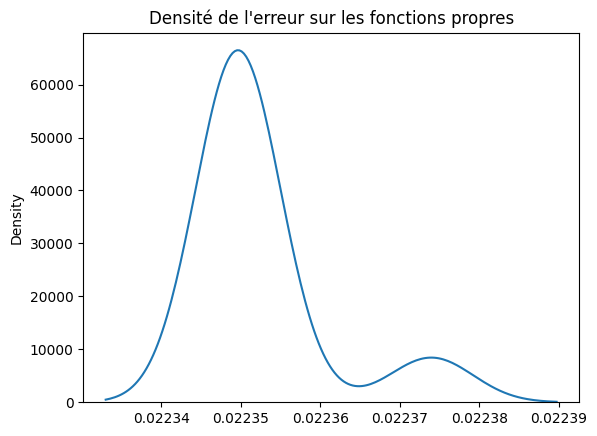

In [21]:
c = np.zeros((sd, 2))
for i in range(sd):
    if (i % 2 == 0):
        c[i, 0] = np.linalg.norm(f1(x, roots1[int(i/2)]) - hv[:, i])
        c[i, 1] = np.linalg.norm(f1(x, roots1[int(i/2)]) + hv[:, i])
    else:
        c[i, 0] = np.linalg.norm(f2(x, roots2[int(i/2)]) - hv[:, i])
        c[i, 1] = np.linalg.norm(f2(x, roots2[int(i/2)]) + hv[:, i])

c = np.min(c, axis=1)

sns.kdeplot(c)
plt.title("Densité de l'erreur sur les fonctions propres")
plt.show()

On voit qu'elles sont bien proches avec une erreur $L^2$ de l'ordre de $10^{-2}$

In [22]:
def Ls(x,l = lambdaK) :
    return (2 * l /((x**2)*(l**2) + 1))

Text(0.5, 1.0, 'Densité erreur sur les valeurs propres')

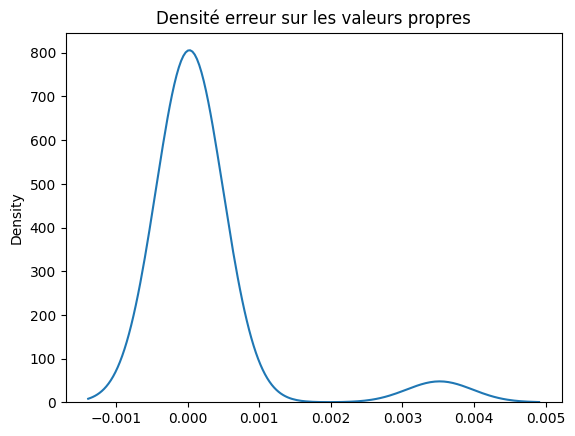

In [23]:
hwLs = np.zeros(2*sd)
hwLs[0::2] = Ls(roots1)
hwLs[1::2] = Ls(roots2)

sns.kdeplot(hwLs - hw[:(2*sd)])
plt.title('Densité erreur sur les valeurs propres')

## CHAMP GAUSSIEN SUR UN DOMAINE DE $\mathbb{R}^2$

### Question 1 (Génération du maillage)

In [24]:
Jn = np.array([[-1, 1], [-1, 1]])
Nx = 20
Ny = 20

dx = np.linspace(Jn[0][0], Jn[0][1], Nx)
dy = np.linspace(Jn[1][0], Jn[1][1], Ny)

X = np.outer(dx, np.ones(Ny))
Y = np.outer(dy, np.ones(Nx))

points = np.concatenate(
    (X.ravel().reshape(Nx*Ny, 1), Y.transpose().ravel().reshape(Nx*Ny, 1)), 1)

tri = sp.Delaunay(points)

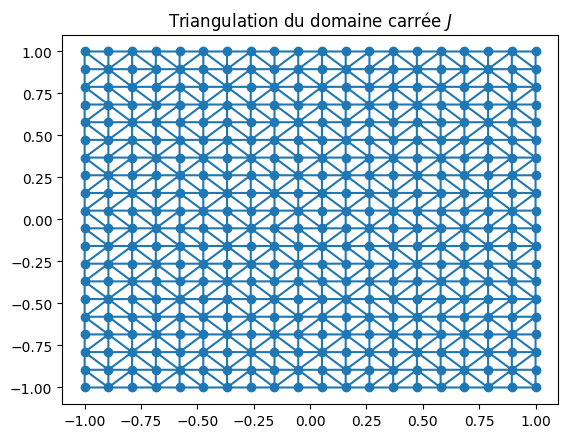

In [25]:
plt.triplot(points[:, 0], points[:, 1], tri.simplices)
plt.scatter(points[:, 0], points[:, 1])
plt.title(f"Triangulation du domaine carrée $J$")
plt.show()


### Question 2 (Décomposition de Karhunen-Loève)

En 1D, on avait cette décomposition $Z = \sum_{n \in \mathbb{N}} \langle Z, \phi_n \rangle \phi_n$

En 2D, on a la même décomposition sauf que les $(\phi_n)_{n \in \mathbb{N}}$ est une famille orthonormée dans $L^2([0,1]^2, \mathbb{R})$.



Décomposition de Karhunen-Loève du champ stochastique $Z(\textit{\textbf{x}}, \omega)$ :

$$\forall \textbf{\textit{x}} \in \mathcal{J}, \forall \omega \in \Omega, Z(\textit{\textbf{x}}, \omega) = \sum_{n \geq 0} \sqrt{\lambda_n} \phi_n(\textit{\textbf{x}}) \xi_n(\omega)$$

avec $\xi_n(\omega) = \frac{1}{\lambda_n} \int_{\mathcal{J}} Z(\textit{\textbf{x}},\omega) \phi(\textit{\textbf{x}}) d\textit{\textbf{x}}$

+ $\mathbb{E}(\xi_n) = 0$
+ $\mathbb{E}(\xi_n \xi_m) = \delta_{n,m}$

et $(\lambda_n, \phi_n)$ valeur et fonction propre de $K$ (i.e. solution de $\int_{\mathcal{J}} K(\textit{\textbf{x}},\textit{\textbf{y}}) \phi(\textit{\textbf{y}}) d\textit{\textbf{y}} = \lambda \phi(\textit{\textbf{x}})$)


Si on souhaite générer des trajectoire de $Z(\textit{\textbf{x}}, \omega)$ un champ aléatoire gaussien alors on prend $\xi_n \sim \mathcal{N}(0,1)$ i.i.d.

$$\int_{\mathcal{J}} K(\textit{\textbf{x}},\textit{\textbf{y}}) \phi(\textit{\textbf{y}}) d\textit{\textbf{y}} = \sum_{T_k \in D_h}\int_{T_k} K(\textit{\textbf{x}},\textit{\textbf{y}}) \phi(\textit{\textbf{y}}) d\textit{\textbf{y}}  \approx \sum_{T_k \in D_h} |T_k| K(\textit{\textbf{x}},\textit{\textbf{y}}_k) \phi(\textit{\textbf{y}}_k) $$

On résout alors le problème suivant pour tout $\textit{\textbf{x}}_l$ barycentre de $T_l \in D_h$

$$(*) \sum_{T_k \in D_h} |T_k| K(\textit{\textbf{x}}_l,\textit{\textbf{y}}_k) \phi(\textit{\textbf{y}}_k) = \lambda \phi(\textit{\textbf{x}}_l)$$

Soient $K \in \mathbb{R}^{N_t \times N_t}$ la matrice tel que $K_{l,k} = K(\textit{\textbf{x}}_l, \textit{\textbf{y}}_k)$ et $\phi \in \mathbb{R}^{N_t}$ le vecteur tel que $\phi_{k} = \phi(\textit{\textbf{y}}_k)$ avec $N_t$ le nombre de triangle.

Ce qui nous donne $$ (*) \Longleftrightarrow  K D\phi = \lambda \phi $$ avec $D = \text{diag}(|T_k|)_{T_k \in D_h}$

La discrétisation nous ramène alors au calcul des valeurs et vecteur propres de la matrice $K D$

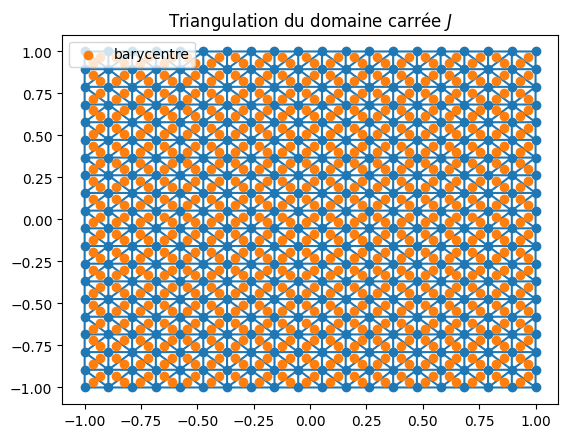

In [26]:
bar = (points[tri.simplices[:, 0], :] +
       points[tri.simplices[:, 1], :]+points[tri.simplices[:, 2], :])/3
plt.triplot(points[:, 0], points[:, 1], tri.simplices)
plt.scatter(points[:, 0], points[:, 1])
plt.scatter(bar[:, 0], bar[:, 1], label="barycentre")
plt.title(f"Triangulation du domaine carrée $J$")
plt.legend()
plt.show()


```Python
distMatrix = sp.distance_matrix(bar, bar, 1)


### Question 3 (Symétrisation du problème)

$KD \phi = \lambda \phi \Leftrightarrow D^{1/2} KD \phi =  D^{1/2} \lambda \phi \Leftrightarrow  D^{1/2} K D^{1/2} D^{1/2}\phi =   \lambda D^{1/2}\phi $ 

Posons $S_K =  D^{1/2} K D^{1/2}$ et $D^{1/2}\phi = \phi_D$, on a le problème $S_K \phi_D = \lambda \phi_D$ avec $S_k$ symétrique

```Python 
# Calcul de D
ne = len(tri.simplices)
D = np.zeros(ne)
for k in range(0, ne):
    n1 = tri.simplices[k, 0]
    n2 = tri.simplices[k, 1]
    n3 = tri.simplices[k, 2]

    x1 = points[n1, 0]
    x2 = points[n2, 0]
    x3 = points[n3, 0]

    y1 = points[n1, 1]
    y2 = points[n2, 1]
    y3 = points[n3, 1]

    t = np.array([x2-x3, y2-y3])
    l1 = np.linalg.norm(t)

    t = np.array([x3-x1, y3-y1])
    l2 = np.linalg.norm(t)

    t = np.array([x1-x2, y1-y2])
    l3 = np.linalg.norm(t)

    p = (l1+l2+l3)/2

    D[k] = np.sqrt(p*(p-l1)*(p-l2)*(p-l3))

# calcul de Sk
Sk = np.matmul(np.diag(D**(1/2)),
               np.matmul(np.exp(- distMatrix / lambdaK), np.diag(D**(1/2))))

```

### Question 4 (Génération de trajectoires)

In [27]:
def GenererComposante2D(Jn, Nx, Ny, partVar, lambdaK):
    dx = np.linspace(Jn[0][0], Jn[0][1], Nx)
    dy = np.linspace(Jn[1][0], Jn[1][1], Ny)

    X = np.outer(dx, np.ones(Ny))
    Y = np.outer(dy, np.ones(Nx))

    points = np.concatenate(
        (X.ravel().reshape(Nx*Ny, 1), Y.transpose().ravel().reshape(Nx*Ny, 1)), 1)

    tri = sp.Delaunay(points)

    bar = (points[tri.simplices[:, 0], :] +
           points[tri.simplices[:, 1], :]+points[tri.simplices[:, 2], :])/3

    distMatrix = sp.distance_matrix(bar, bar, 1)

    # Calcul de D
    ne = len(tri.simplices)
    D = np.zeros(ne)
    for k in range(0, ne):
        n1 = tri.simplices[k, 0]
        n2 = tri.simplices[k, 1]
        n3 = tri.simplices[k, 2]

        x1 = points[n1, 0]
        x2 = points[n2, 0]
        x3 = points[n3, 0]

        y1 = points[n1, 1]
        y2 = points[n2, 1]
        y3 = points[n3, 1]

        t = np.array([x2-x3, y2-y3])
        l1 = np.linalg.norm(t)

        t = np.array([x3-x1, y3-y1])
        l2 = np.linalg.norm(t)

        t = np.array([x1-x2, y1-y2])
        l3 = np.linalg.norm(t)

        p = (l1+l2+l3)/2

        D[k] = np.sqrt(p*(p-l1)*(p-l2)*(p-l3))

    # calcul de Sk
    Sk = np.matmul(np.diag(D**(1/2)),
                   np.matmul(np.exp(- distMatrix / lambdaK), np.diag(D**(1/2))))

    # Calcul des valeurs propres et vecteur propres de la matrice Sk
    Skw, Skv = np.linalg.eig(Sk)

    # Renormalisation
    Skv = np.matmul(np.diag(D**(-1/2)), Skv)

    # Troncature
    tracehK = sum(Skw)
    Nkl = sum(np.cumsum(Skw) < tracehK*partVar) + 1

    return [bar, tri, Skw, Skv, Nkl]


In [28]:
Jn = np.array([[-1, 1], [-1, 1]])
Nx = 20
Ny = 20
partVar = 0.95
lambdaK = 5

bar, tri, Skw, Skv, Nkl = GenererComposante2D(Jn, Nx, Ny, partVar, lambdaK)

SkwTronc = Skw[:Nkl]

# Calcul des trajectoires
nbTraject = 1
hwTronc = Skw[:Nkl]
Phin = Skv[:, :Nkl]
Xink = np.random.randn(nbTraject, Nkl)
lnXin = np.matmul(Xink, np.diag(np.sqrt(hwTronc)))

Z = np.matmul(lnXin, Phin.transpose()).transpose()

cells = [("triangle", tri.simplices)]
data = {
    "C": [Z]
}
mesh = meshio.Mesh(points, cells, cell_data=data)

mesh.write("2DOutput/output0.vtu")


Warning: VTU requires 3D points, but 2D points given. Appending 0 third component.

#### (a) génération en 2D

In [29]:
nbTraject = 1000
hwTronc = Skw[:Nkl]
Phin = Skv[:, :Nkl]
Xink = np.random.randn(nbTraject, Nkl)
lnXin = np.matmul(Xink, np.diag(np.sqrt(hwTronc)))

Z = np.matmul(lnXin, Phin.transpose()).transpose()


In [ ]:
cells = [("triangle", tri.simplices)]
for i in range(nbTraject):
    data = {
        "C": [Z[:,i].reshape(Z.shape[0],1)]
    }
    mesh = meshio.Mesh(points, cells, cell_data=data)

    mesh.write("2DOutput/output{}.vtu".format(i+1))

Ici on veut illustrer le fait qu'en chaque point, on a une variable aléatoire qui suit une loi normale centrée réduite.

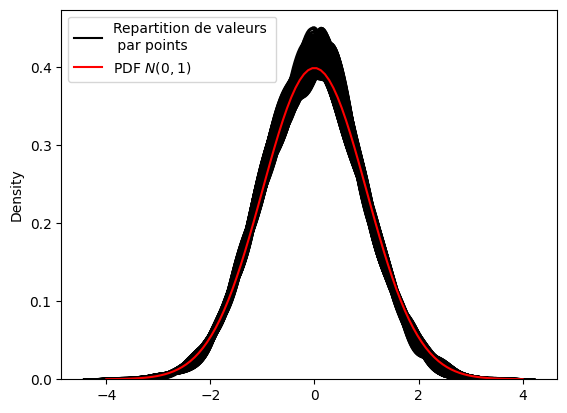

In [31]:
x = np.linspace(-4, 4, 100)
y = NormalPDF(x)
for i in range(Z.shape[0]-1):
    # plt.hist(Z[i, :], color='k', alpha=1/N, density= True)
    sns.kdeplot(Z[i,:], c = 'k')
sns.kdeplot(Z[Z.shape[0]-1, :], c = 'k', label = "Repartition de valeurs \n par points")

plt.plot(x,y, c = 'red', label = f"PDF $N(0,1)$")
plt.legend()
plt.show()


Ici on remarque les valeurs sont bien dispersé sont comprises entre -3 et 3 avec probabilité 0.9973.


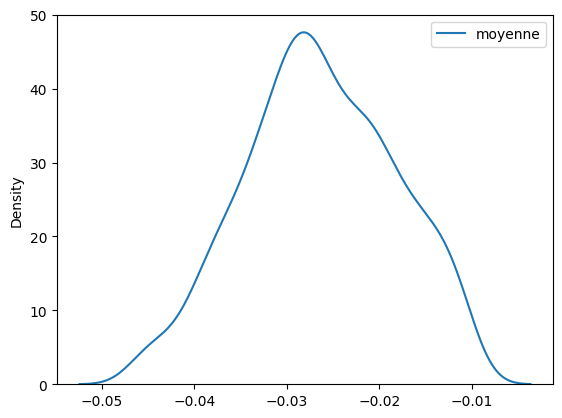

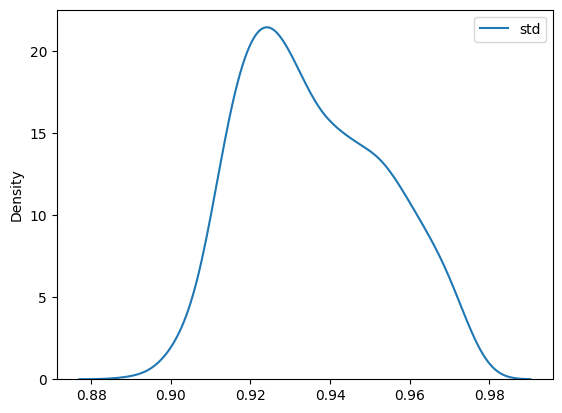

In [32]:
moyenne_approx = np.mean(Z, axis=1)
std_approx = np.std(Z, axis=1)
sns.kdeplot(moyenne_approx, label = "moyenne")
plt.legend()
plt.show()
sns.kdeplot(std_approx, label = "std")
plt.legend()
plt.show()

### Question 5 (Produit tensoriel)

In [ ]:
# Enregistrement des modes propres
cells = [("triangle", tri.simplices)]
for i in range(Nkl):
    data = {
        "C": [Phin[:,i].reshape(Phin.shape[0],1)]
    }
    mesh = meshio.Mesh(points, cells, cell_data=data)

    mesh.write("2DOutput/Phi{}.vtu".format(i))

#### (c) la solution analytique de KL

$$A_K : f \mapsto \int_{\mathcal{J}} K_{\lambda} (\textbf{\textit{x}},\textbf{\textit{y}}) f(\textbf{\textit{y}})d\textbf{\textit{y}}$$

Prenoms $f_1$ et $f_2$ deux fonctions à une variable d'entrée tel que $T_K(f_1) = L_1 f_1$ et $T_K(f_2) = L_2 f_2$

$f : (x_1, x_2) \in [-1,1]^2 \mapsto f_1(x_1) f_1(x_2) $

On a $A_K (f) (\textbf{\textit{x}}) = \int_{[-1,1]^2} e^{-\frac{\lVert \textbf{\textit{x}} - \textbf{\textit{y}} \rVert}{\lambda}} f(\textbf{\textit{x}}, \textbf{\textit{y}}) d \textbf{\textit{y}} = \int_{[-1,1]^2} e^{-\frac{|x_1 - y_1|}{\lambda}} e^{-\frac{|x_2 - y_2|}{\lambda}} f(y_1, y_2) d y_1 d y_2$

$ = \int_{-1}^1 \int_{-1}^1  e^{-\frac{|x_1 - y_1|}{\lambda}} e^{-\frac{|x_2 - y_2|}{\lambda}} f_1(y_1) f_2(y_2) d y_1 d y_2 = \int_{-1}^1 \left(\int_{-1}^1  e^{-\frac{|x_1 - y_1|}{\lambda}}  f_1(y_1)  d y_1 \right) e^{-\frac{|x_2 - y_2|}{\lambda}} f_2(y_2) d y_2$

$ = \left(\int_{-1}^1  e^{-\frac{|x_1 - y_1|}{\lambda}}  f_1(y_1)  d y_1 \right) \left(\int_{-1}^1  e^{-\frac{|x_2 - y_2|}{\lambda}} f_2(y_2) d y_2 \right) = L_1 f_1(x_1) L_2 f_2(x_2) = L_1 L_2 f_1(x_1)  f_2(x_2) = L_1 L_2 f(x_1, x_2) = L_1 L_2 f(\textbf{\textit{x}})  $

On sait donc le tensorisation de deux fonctions propres de l'opérateur $T_K$ est une fonction propre de l'opérateur $A_K$



Maintenant on veut montrer la réciproque, bon ambitieux

Maintenant pour la génération de trajectoire, il faut tenir compte des espaces propres issus de la tensoriation. Si je note $P$ les valeurs propres en 2D et $\varphi$ les fonctions propres et $L$ ceux en 1D, et $\phi$ les fonctions propres, on a deux cas :

+ $P_l = L_i^2$, on a  $\varphi_l (x_1, x_2) = \phi_i(x_1) \phi_i(x_2)$ est une fonction symétrique. L'espace propre engendré est alors de dimension 1.

  Dans ce cas là, la version numérique sera la même que la solution analytique au signe près.
  
+ $P_l = L_i L_j$, on a $\varphi_l (x_1, x_2) = \phi_i(x_1) \phi_j(x_2)$ ou $\varphi_l (x_1, x_2) = \phi_j(x_1) \phi_i(x_2)$. L'espace propre engendré est alors de dimension 2.

  Dans ce cas là, on a deux espaces dirigés par deux fonctions orthonormés engendrés par les fonctions $f_1 : (x_1, x_2) \mapsto \phi_i(x_1) \phi_j(x_2)$ et $f_2 : (x_1, x_2) \mapsto \phi_j(x_1) \phi_i(x_2)$

  $\langle f_1 + f_2, f_1 - f_2 \rangle = \lVert f_1 \rVert^2 - \lVert f_2 \rVert^2 = 1 - 1 = 0$

  $A_K(f_1 + f_2) =  A_K(f_1)+ A_K(f_2) = P_l f_1 + P_l f_2 = P_l (f_1 + f_2)$

  $A_K(f_1 - f_2) =  A_K(f_1) - A_K(f_2) = P_l f_1 - P_l f_2 = P_l (f_1 - f_2)$

  $\left\{\frac{1}{\sqrt{2}} (f_1 + f_2), \frac{1}{\sqrt{2}} (f_1 - f_2)\right\}$ est une base orthonormé de l'espace propre associé à la propre $P_l$

  Les versions numériques de fonctions propres seront au signe près ces deux fonctions.
  

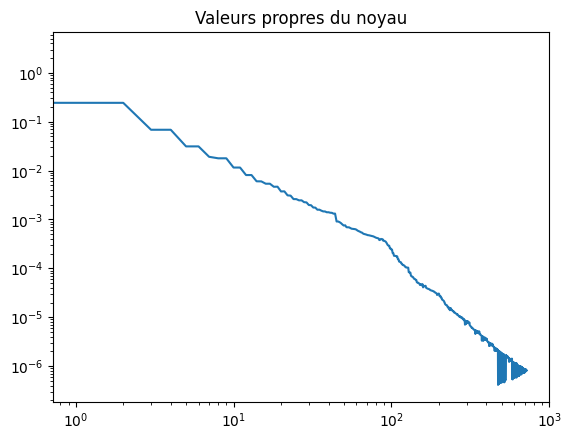

In [49]:
plt.loglog(Skw)
plt.title(f"Valeurs propres du noyau")
plt.show()

Ici on a une réalisation numérique des valeurs propres de l'opérateur en 2D, et on voit les plateaux qui correspondent au doublons de valeurs propres qui correspondent au espace propre de dimension 2.

On va maintenant générer les fonctions propres en 1D avec les solutions analytiques obtenu

In [ ]:
x = np.sort(np.unique(bar[:,0]))




#### (b) génération par produit cartésien 1Dx1D

On remarque à partir de la solution analytique que la valeur propre associé à une fonction propre en 2D est le produit des deux valeurs propres des deux fonctions qui dont la tensorisation donne la fonction.

Pour séléctionner les fonctions propres on va prendre 

$$(*) \sum_{j = 1}^{N}h_j K(x_{i + \frac{1}{2}},y_{j+\frac{1}{2}}) \phi(y_{j+\frac{1}{2}}) = \lambda \phi(x_{i + \frac{1}{2}})$$


In [33]:
x = np.sort(np.unique(bar[:,0]))

hs = np.concatenate((x[1:] - x[:-1],[x[-1] - x[-2]]))

# Calcul de la matrice noyau
K = np.exp(-np.abs(np.subtract.outer(x, x)) / lambdaK)

# Calcul des valeurs propres et vecteur propres de la matrice h K

# calcul de Sk
hK = np.matmul(np.diag(hs**(1/2)),
               np.matmul(K, np.diag(hs**(1/2))))

# Calcul des valeurs propres et vecteur propres de la matrice Sk

hw, hv = np.linalg.eig(hK)

# Renormalisation
hv = np.real(np.matmul(np.diag(hs**(-1/2)), hv))

hw = np.real(hw)

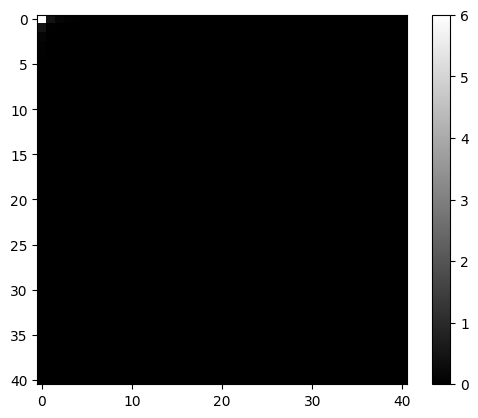

In [34]:
plt.imshow(2 * np.outer(hw, hw), cmap = 'gray')
plt.colorbar()

On doit ranger les fonctions tensorisé par ordre décroissant de la valeur

In [103]:
# np.cumsum(np.unique(2 * np.outer(hw, hw))[::-1]) <= 

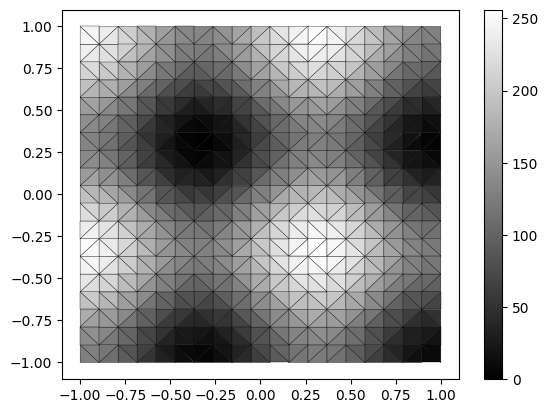

In [35]:
X = np.outer(x, np.ones(x.shape[0]))
Y = np.outer(x, np.ones(x.shape[0]))

XY = np.concatenate(
    (X.ravel().reshape(x.shape[0]*x.shape[0], 1), Y.transpose().ravel().reshape(x.shape[0]*x.shape[0], 1)), 1)

distMatrix = sp.distance_matrix(XY, bar, 1)
isABar = (distMatrix == 0).any(axis = 1)

mybar = XY[isABar]

p = tri.find_simplex(mybar)
s = np.argsort(p)

#Affichage
k = 3
l = 0                          
s1 = np.outer(hv[:,k], hv[:,l])
s2 = np.outer(hv[:,l], hv[:,k])
p = -(s1 - s2)

p = p.ravel()[isABar][s]

c = p
colors = np.int64((c - min(c))/(max(c) - min
                                (c))*256)
                                
plt.tripcolor(points[:, 0], points[:, 1], tri.simplices,
              facecolors=colors, edgecolors='k', cmap='gray')
plt.colorbar()
plt.show()

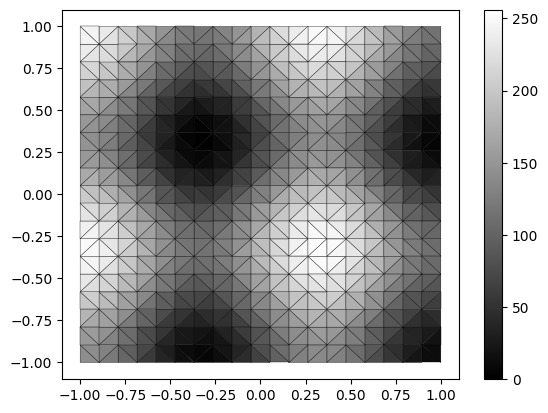

In [36]:
#Affichage
c = Phin[:,5]
colors = np.int64((c - min(c))/(max(c) - min
                                (c))*256)
                                
plt.tripcolor(points[:, 0], points[:, 1], tri.simplices,
              facecolors=colors, edgecolors='k', cmap='gray')
plt.colorbar()
plt.show()

Rq final de la journée :
Pour le 2D, le 1D nous appris une chose, c'est que les f numériques peuvent être +- f réel.

Ce qui fait qu'en fait, quand on a deux fonctions propres 2D associés à une même valeur propres déjà elles sont additionnés.

Mais en plus, elle peut prendre n'importe quel signe individuellement

On a maintenant deux manières de générer la base approché de fonction propre en 1D. Soit en discretisant l'opérateur $T_K$, soit en utilisant les solutions analytiques(dont il faut numériquement déterminer les $\nu$)

In [41]:
f = open("./middle/middle{}.txt".format(4), "r")
print(f.read())

⠀⠀⠀⠀⠀⣠⡾⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⢰⡿⣼⣦⡻⣷⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣤⣾⣿⣷⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⣼⠇⣿⠘⣷⡙⣷⡀⠀⠀⠀⢀⣀⣀⣀⣀⣀⠀⠀⠀⠀⠀⠀⢀⣴⡿⢋⣵⣦⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⣿⢠⡟⢀⣼⡇⠘⣿⠶⠟⠛⠛⠛⠛⠛⠛⠛⠛⠿⠿⣶⣦⣤⡿⢋⣴⠋⠀⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⢀⣿⠈⠿⠛⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⢿⡆⠻⣦⣠⣿⣿⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⢸⡏⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠉⢹⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⣼⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⣤⣤⣄⡀⠀⠀⠀⢸⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⢠⣿⠀⠀⠀⠀⠀⠀⣾⡟⢻⣿⠷⣦⡀⠀⠀⠀⠀⢀⣶⡟⢹⣿⣏⣹⡿⠀⠀⠀⠸⣿⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⣼⡇⠀⠀⠀⠀⠀⠀⠙⠻⠾⢿⣶⣾⡷⣀⠀⠀⠐⡾⠉⠛⠛⠛⠛⠉⠀⠀⠀⠀⠀⢿⣇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⠂⠀⠀⢿⠆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⢸⡿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⣿⣿⣿⣶⠆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⣼⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣤⠐⣶⢄⣀⠘⢿⡟⠁⡀⢀⣔⢷⣄⠀⠀⠀⠀⠀⠀⠸⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠿⣶⣤⣭⣤⣾⢷⣤⣛⣈⣥⣼⠟⠀⠀⠀⠀⠀⠀⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡉⠉⠀⠀⢉⡉⠉⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⢸⡟⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠿⠶⠶⠶⠟⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢿⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣷⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢿⣆⠀⠀⠀⠀⠀⠀⠀⠀
⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⣧⡀⠀⠀⠀⠀⠀⠀
⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢹⣧⠀⠀⠀⠀⠀⠀
⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⣶⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢻⣇⠀⠀⠀⠀⠀
⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣴⡟⣼⡟⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

https://emojicombos.com/double-middle-finger-ascii-art